# DEMETER2 in Stan

In [1]:
import pystan
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az
from pathlib import Path
import seaborn as sns
from timeit import default_timer as timer
import warnings
import re
from notebook_modules.pystan_helpers import StanModel_cache

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

modeling_data_dir = Path('../modeling_data')

warnings.filterwarnings(action='ignore', 
                        message='Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won\'t be used')

## Data preparation

In [2]:
modeling_data = pd.read_csv(modeling_data_dir / 'subset_modeling_data.csv')
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


## Exploratory data analysis

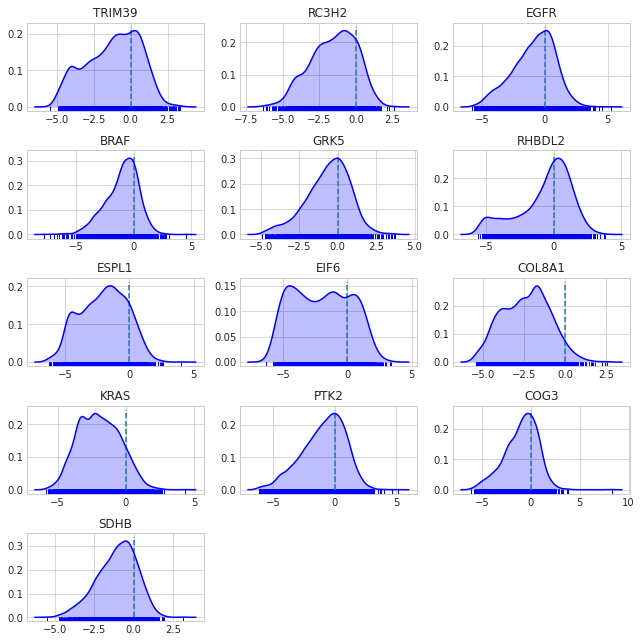

In [3]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(5, 3, figsize=(9, 9))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=False, rug=True, ax=ax, kde_kws={'shade': True}, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

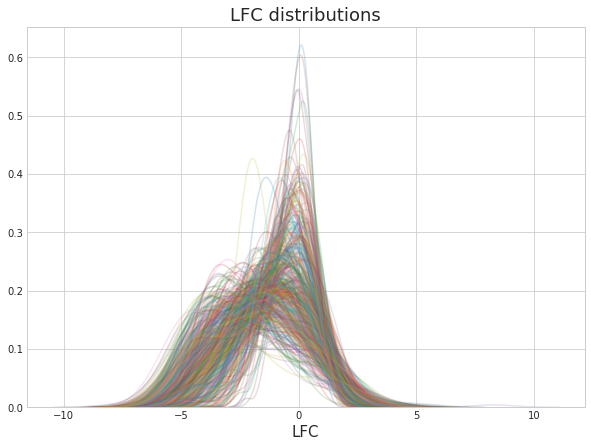

In [4]:
cell_lines = set(modeling_data.cell_line.to_list())
for cell_line in cell_lines:
    lfc = modeling_data[modeling_data.cell_line == cell_line].lfc
    sns.distplot(lfc, kde=True, hist=False, label=None, kde_kws={'alpha': 0.2})

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.show()

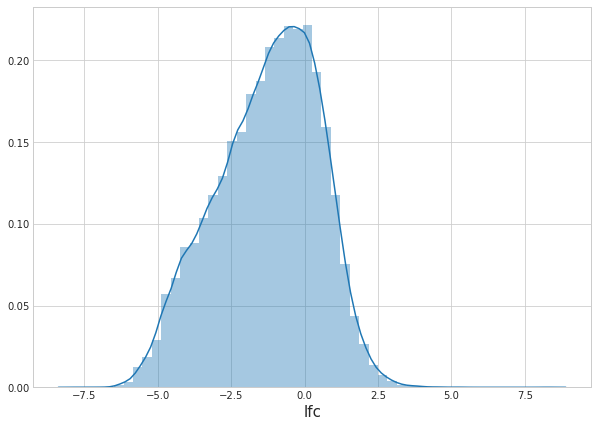

In [5]:
sns.distplot(modeling_data.lfc)
plt.show()

In [6]:
modeling_data[['barcode_sequence', 'gene_symbol']].drop_duplicates().groupby('gene_symbol').count()

,barcode_sequence
gene_symbol,
BRAF,8
COG3,5
COL8A1,5
EGFR,19
EIF6,5
ESPL1,5
GRK5,5
KRAS,11
PTK2,23


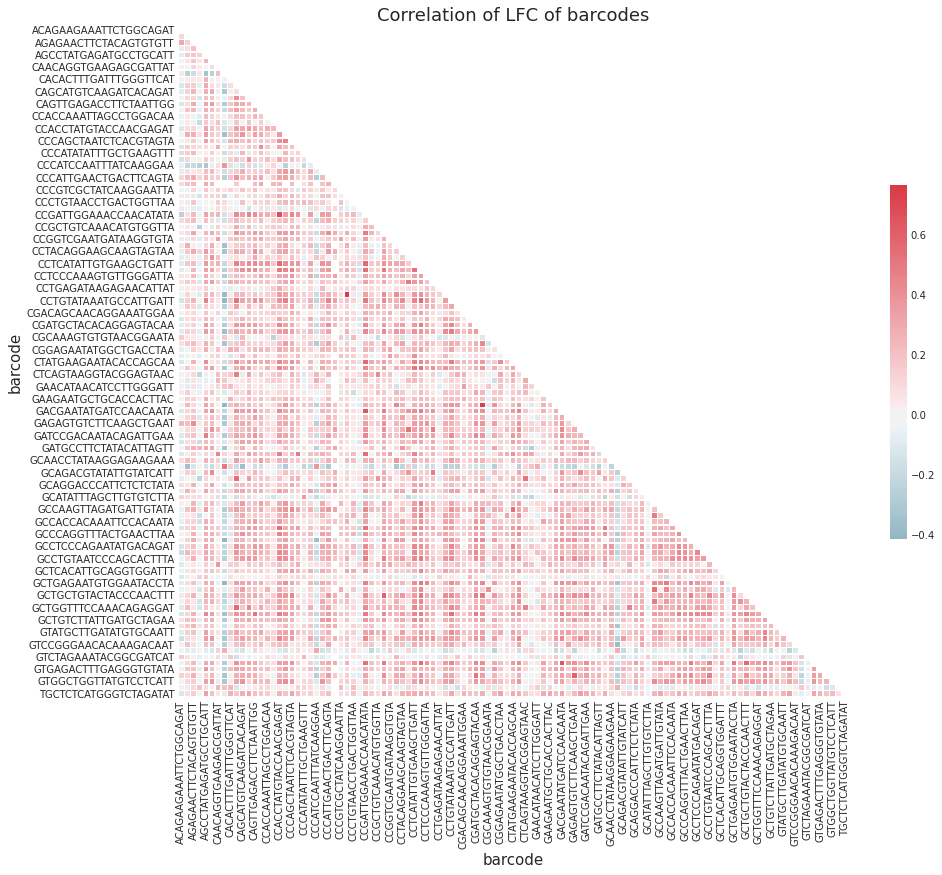

In [7]:
lfc_corr = modeling_data \
    .pivot(index='cell_line', columns='barcode_sequence', values='lfc') \
    .corr()

mask = np.triu(np.ones_like(lfc_corr, dtype=np.bool), k=0)
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lfc_corr, mask=mask, 
            cmap=cmap, center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.xlabel('barcode')
plt.ylabel('barcode')
plt.title('Correlation of LFC of barcodes')
plt.show()

## Modeling

In [8]:
models_dir = Path('..', 'models')

In [9]:
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


Select only a few cell lines while model building.

In [10]:
len(np.unique(modeling_data.cell_line))

501

In [11]:
np.random.seed(123)
cell_lines = np.random.choice(np.unique(modeling_data.cell_line), 40)
modeling_data = modeling_data[modeling_data.cell_line.isin(cell_lines)]
modeling_data.shape

(3334, 5)

In [12]:
np.unique(modeling_data.gene_symbol)

array(['BRAF', 'COG3', 'COL8A1', 'EGFR', 'EIF6', 'ESPL1', 'GRK5', 'KRAS',
       'PTK2', 'RC3H2', 'RHBDL2', 'SDHB', 'TRIM39'], dtype=object)

In [13]:
# model_testing_genes = ['COG3', 'KRAS', 'COL8A1', 'EIF6']
# modeling_data = modeling_data[modeling_data.gene_symbol.isin(model_testing_genes)]

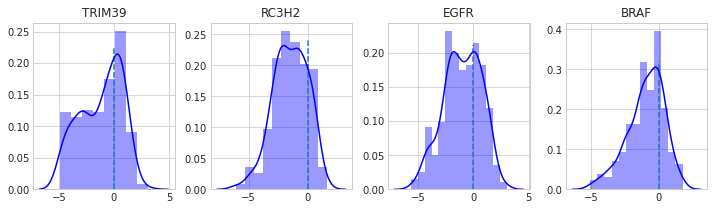

In [14]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=True, ax=ax, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)

fig.tight_layout(pad=1.0)
plt.show()

In [15]:
def add_categorical_idx(df, col):
    df[f'{col}_idx'] = df[col].astype('category').cat.codes + 1
    return df

for col in ['barcode_sequence', 'cell_line', 'gene_symbol']:
    modeling_data = add_categorical_idx(modeling_data, col)

modeling_data = modeling_data.reset_index(drop=True)
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol,barcode_sequence_idx,cell_line_idx,gene_symbol_idx
0,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6,1,11,5
1,ACAGAAGAAATTCTGGCAGAT,dbtrg05mg_central_nervous_system,2.145082,2,EIF6,1,9,5
2,ACAGAAGAAATTCTGGCAGAT,bt20_breast,0.932751,2,EIF6,1,3,5
3,ACAGAAGAAATTCTGGCAGAT,sw1783_central_nervous_system,1.372030,2,EIF6,1,36,5
4,ACAGAAGAAATTCTGGCAGAT,kns60_central_nervous_system,0.803835,2,EIF6,1,18,5


Binary matrix of $[shRNA \times gene]$.

In [16]:
shrna_gene_matrix = modeling_data[['barcode_sequence_idx', 'gene_symbol_idx']] \
    .drop_duplicates() \
    .reset_index(drop=True) \
    .assign(value = lambda df: np.ones(df.shape[0], dtype=int)) \
    .pivot(index='barcode_sequence_idx', columns='gene_symbol_idx', values='value') \
    .fillna(0) \
    .to_numpy() \
    .astype(int)

shrna_gene_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
shrna_gene_matrix.shape

(109, 13)

## Model 1. Just an intercept

$$
D \sim N(\mu, \sigma) \\
\mu = \alpha \\
\alpha \sim N(0, 5) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

**Model data.**

In [18]:
d2_m1_data = {
    'N': int(modeling_data.shape[0]),
    'y': modeling_data.lfc
}

**Compile model.**

In [19]:
d2_m1_file = models_dir / 'd2_m1.cpp'
d2_m1 = StanModel_cache(file=d2_m1_file.as_posix())

Using cached StanModel.


In [20]:
d2_m1_fit = d2_m1.sampling(data=d2_m1_data, iter=2000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [21]:
pystan.check_hmc_diagnostics(d2_m1_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [22]:
az_d2_m1 = az.from_pystan(posterior=d2_m1_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m1)
az.summary(az_d2_m1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.290,0.030,-1.344,-1.230,0.001,0.001,1544.0,1537.0,1554.0,1458.0,1.0
sigma,1.736,0.021,1.695,1.775,0.001,0.000,1627.0,1625.0,1638.0,1385.0,1.0


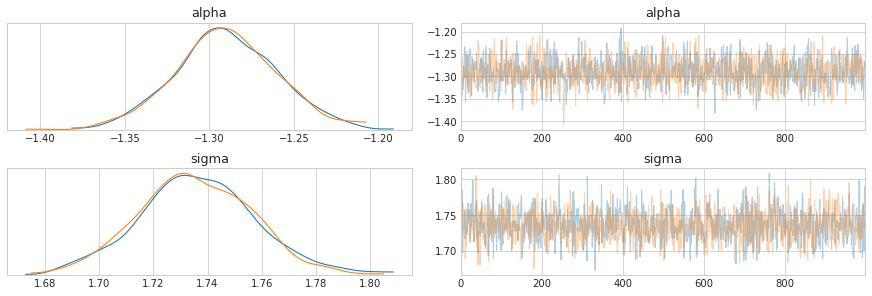

In [23]:
az.plot_trace(az_d2_m1)
plt.show()

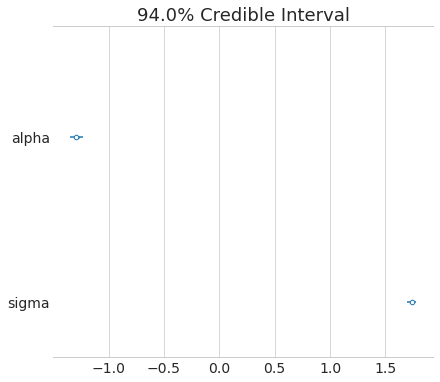

In [24]:
az.plot_forest(az_d2_m1, combined=True)
plt.show()

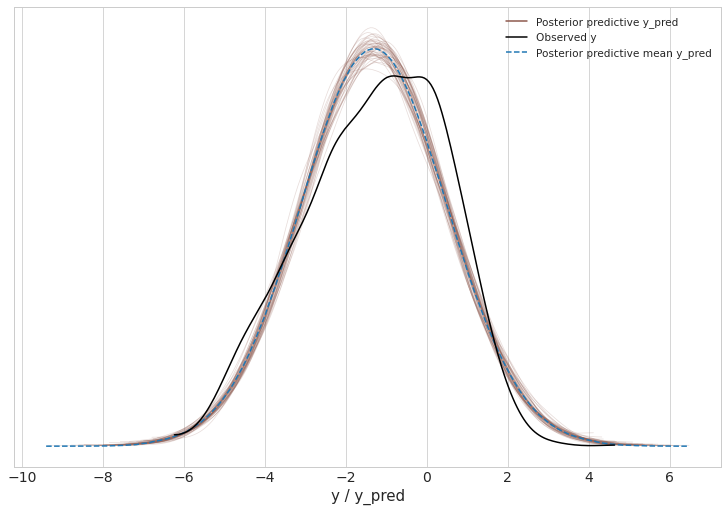

In [25]:
az.plot_ppc(az_d2_m1, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

## Model 2. Varying intercept by shRNA

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} \\
\alpha \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
\mu_{\alpha} \sim N(0, 2) \\
\sigma_{\alpha} \sim \text{HalfCauchy}(0, 2) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

### Generative model for a prior predictive check

In [26]:
N = 1000
S = 100
shrna_barcodes = list(range(1, S+1))
shrna_barcodes_idx = np.repeat(shrna_barcodes, N/S)

In [27]:
d2_m2_gen_data = {
    'N': N,
    'S': S,
    'shrna': shrna_barcodes_idx
}

In [28]:
d2_m2_gen_file = models_dir / 'd2_m2_generative.cpp'
d2_m2_gen = StanModel_cache(file=d2_m2_gen_file.as_posix())

Using cached StanModel.


In [29]:
d2_m2_gen_fit = d2_m2_gen.sampling(data=d2_m2_gen_data, 
                                   iter=10, warmup=0, chains=1, 
                                   algorithm='Fixed_param')

In [30]:
az_d2_m2_gen = az.from_pystan(d2_m2_gen_fit)

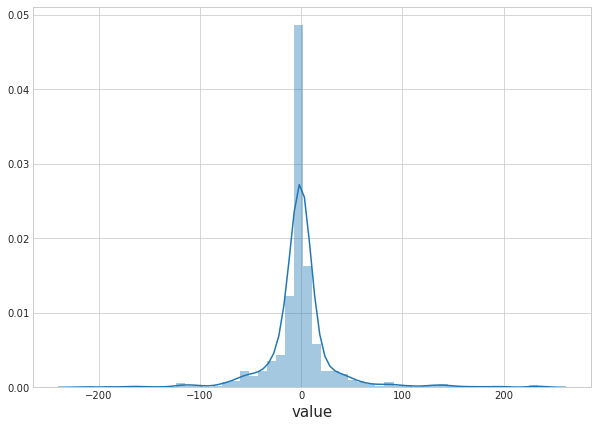

In [31]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('alpha\[')]
sns.distplot(df.value)
plt.show()

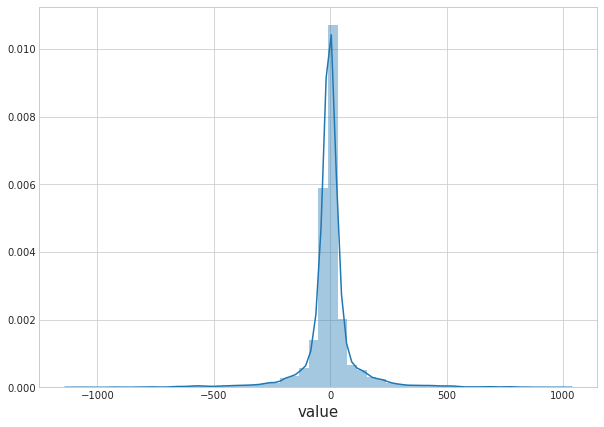

In [32]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('y_pred')]
sns.distplot(df.value)
plt.show()

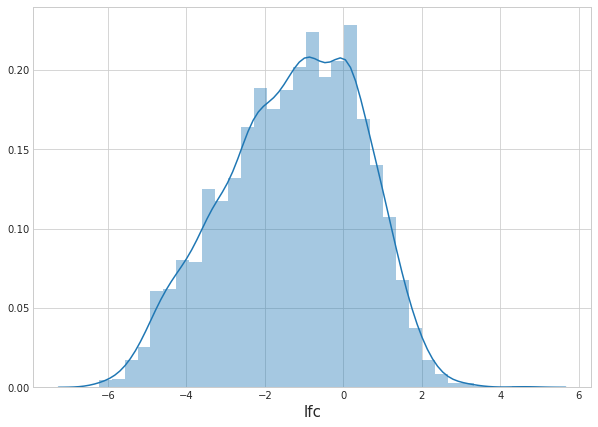

In [33]:
sns.distplot(modeling_data.lfc)
plt.show()

**Model data**

In [34]:
d2_m2_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    
    'y': modeling_data.lfc,
}

In [35]:
d2_m2_data['S']

109

**Compile model.**

In [36]:
d2_m2_file = models_dir / 'd2_m2.cpp'
d2_m2 = StanModel_cache(file=d2_m2_file.as_posix())

Using cached StanModel.


In [37]:
d2_m2_fit = d2_m2.sampling(data=d2_m2_data, iter=1000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [38]:
pystan.check_hmc_diagnostics(d2_m2_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [39]:
az_d2_m2 = az.from_pystan(posterior=d2_m2_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m2)
az.summary(az_d2_m2).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-1.217,0.123,-1.451,-0.997,0.003,0.002,1376.0,1376.0,1373.0,766.0,1.00
sigma_alpha,1.278,0.099,1.113,1.485,0.003,0.002,1360.0,1277.0,1485.0,516.0,1.02
alpha[0],0.719,0.191,0.373,1.075,0.005,0.003,1727.0,1544.0,1715.0,681.0,1.00
alpha[1],-0.255,0.203,-0.664,0.092,0.005,0.005,1570.0,849.0,1585.0,493.0,1.01
alpha[2],-0.778,0.194,-1.107,-0.381,0.005,0.003,1778.0,1585.0,1766.0,663.0,1.00


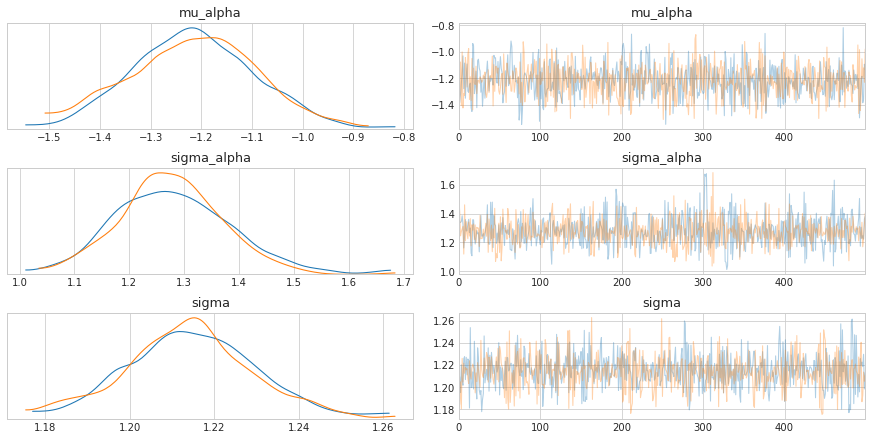

In [40]:
az.plot_trace(az_d2_m2, var_names=['mu_alpha', 'sigma_alpha', 'sigma'])
plt.show()

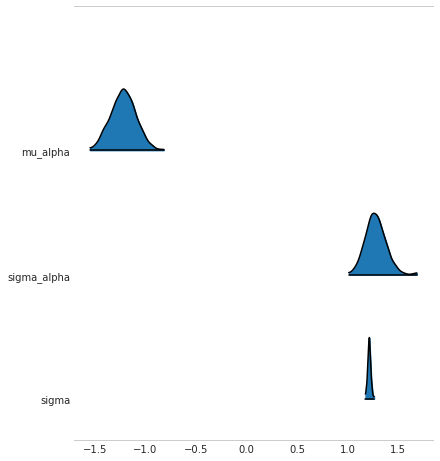

In [41]:
az.plot_forest(az_d2_m2, kind='ridgeplot', combined=True, 
               var_names=['mu_alpha', 'sigma_alpha', 'sigma'])
plt.show()

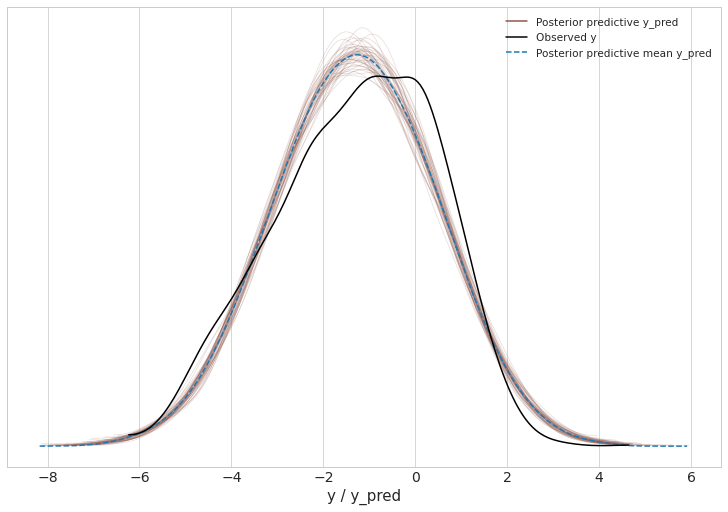

In [42]:
az.plot_ppc(az_d2_m2, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [43]:
d2_m2_fit.to_dataframe().head()

,chain,draw,warmup,mu_alpha,sigma_alpha,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],...,y_pred[3332],y_pred[3333],y_pred[3334],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,-1.216304,1.320074,0.858848,-0.079075,-0.689408,0.035510,-2.338883,...,-3.103248,-1.507661,-1.357500,-2401.906637,0.665830,0.456077,3,7,0,2447.141875
1,0,1,0,-1.381507,1.342428,0.765038,0.439353,-0.847838,0.306467,-2.652954,...,-2.096748,0.232128,-0.643649,-2398.727111,0.987719,0.456077,3,7,0,2458.928582
2,0,2,0,-1.318055,1.338197,0.840429,-0.438901,-0.682010,0.177382,-2.262491,...,-1.993755,-2.202195,-0.465666,-2392.949441,0.986222,0.456077,3,7,0,2447.152468
3,0,3,0,-1.235655,1.344549,0.762180,-0.008853,-0.906560,0.241614,-2.313299,...,-1.567251,-3.409178,-0.022308,-2391.944379,0.928427,0.456077,3,7,0,2446.184185
4,0,4,0,-1.165185,1.384646,0.921878,-0.049478,-0.970616,0.699255,-2.245375,...,-1.968520,-2.230411,-1.563791,-2392.961858,0.857742,0.456077,3,7,0,2449.571241


## Model 3. Another varying intercept for target gene

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} + g_{i|l}\\
\alpha_s \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
g_l \sim N(\mu_g, \sigma_g) \\
\mu_{\alpha} \sim N(0, 2) \quad \sigma_{\alpha} \sim \text{HalfCauchy}(0, 10) \\
\mu_{g} \sim N(0, 2) \quad \sigma_{g} \sim \text{HalfCauchy}(0, 10) \\
\sigma \sim \text{HalfCauchy}(0, 10)
$$

In [44]:
d2_m3_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

In [45]:
d2_m3_file = models_dir / 'd2_m3.cpp'
d2_m3 = StanModel_cache(file=d2_m3_file.as_posix())

Using cached StanModel.


In [46]:
d2_m3_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m3_fit = d2_m3.sampling(data=d2_m3_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m3_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [47]:
pystan.check_hmc_diagnostics(d2_m3_fit)

{'n_eff': True,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': True}

In [48]:
az_d2_m3 = az.from_pystan(posterior=d2_m3_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m3)
az.summary(az_d2_m3).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-0.243,1.362,-3.347,2.026,0.421,0.307,10.0,10.0,11.0,23.0,1.29
sigma_alpha,1.229,0.093,1.053,1.399,0.004,0.003,673.0,673.0,665.0,1310.0,1.01
mu_g,-1.046,1.361,-3.360,2.028,0.420,0.313,11.0,10.0,11.0,20.0,1.29
sigma_g,0.420,0.201,0.075,0.773,0.012,0.009,271.0,271.0,255.0,444.0,1.02
alpha[0],2.003,1.417,-1.169,4.495,0.423,0.328,11.0,10.0,12.0,19.0,1.27


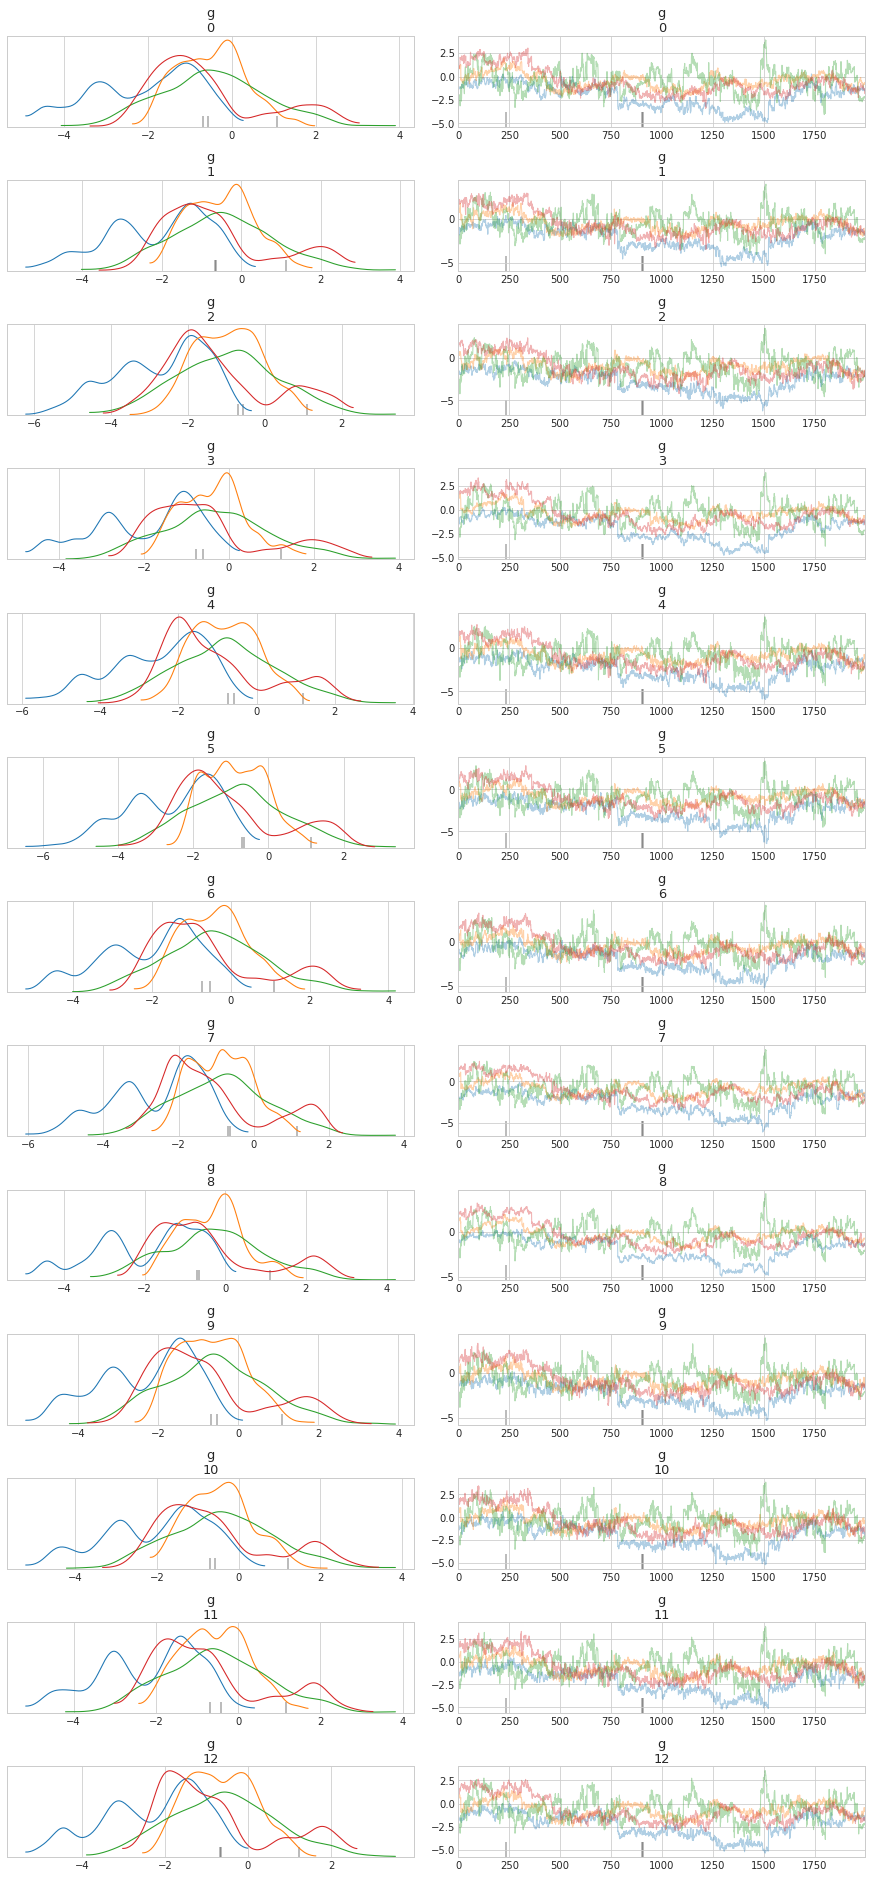

In [49]:
az.plot_trace(az_d2_m3, var_names=['g'])
plt.show()

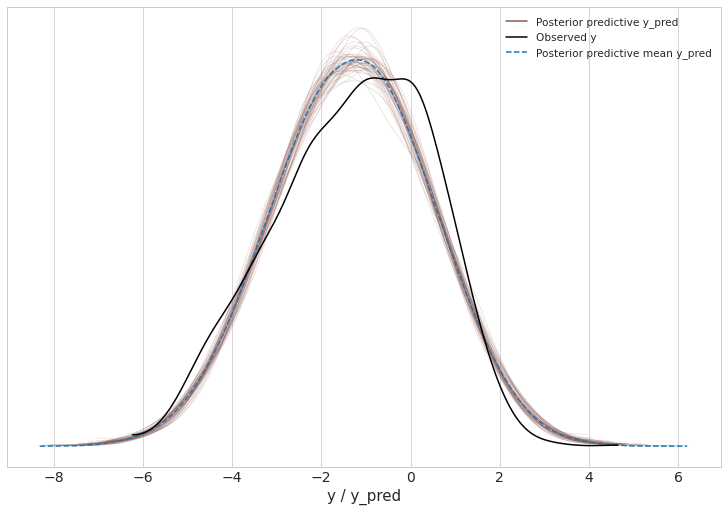

In [50]:
az.plot_ppc(az_d2_m3, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [51]:
fit3_summary = az.summary(az_d2_m3)

In [52]:
fit3_alpha_summary = fit3_summary[fit3_summary.index.str.contains('alpha\[')]
shrna_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_alpha_summary.index]
shrna_idx = [int(a) + 1 for a in shrna_idx]
fit3_alpha_summary = fit3_alpha_summary \
    .assign(barcode_sequence_idx = shrna_idx) \
    .set_index('barcode_sequence_idx') \
    .join(modeling_data[['barcode_sequence_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('barcode_sequence_idx'))
fit3_alpha_summary.head(10)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gene_symbol
barcode_sequence_idx,,,,,,,,,,,,
1,2.003,1.417,-1.169,4.495,0.423,0.328,11.0,10.0,12.0,19.0,1.27,EIF6
2,0.602,1.408,-2.490,3.177,0.415,0.301,12.0,12.0,12.0,21.0,1.26,GRK5
3,0.502,1.420,-2.617,3.049,0.425,0.308,11.0,11.0,12.0,20.0,1.27,EIF6
4,1.029,1.408,-2.161,3.550,0.424,0.312,11.0,11.0,11.0,18.0,1.27,EGFR
5,-0.780,1.437,-3.646,2.062,0.436,0.317,11.0,11.0,11.0,18.0,1.28,COL8A1
6,-0.164,1.416,-3.275,2.372,0.432,0.314,11.0,11.0,11.0,18.0,1.28,KRAS
7,0.057,1.414,-3.096,2.588,0.425,0.309,11.0,11.0,12.0,24.0,1.27,PTK2
8,1.777,1.415,-1.274,4.414,0.427,0.330,11.0,10.0,12.0,22.0,1.27,PTK2
9,0.957,1.412,-2.238,3.458,0.424,0.308,11.0,11.0,12.0,21.0,1.26,PTK2


In [53]:
fit3_gene_summary = fit3_summary[fit3_summary.index.str.contains('g\[')]
gene_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_gene_summary.index]
gene_idx = [int(a) + 1 for a in gene_idx]
fit3_gene_summary = fit3_gene_summary \
    .assign(gene_symbol_idx = gene_idx) \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('gene_symbol_idx')) \
    .reset_index(drop=False)
fit3_gene_summary.head(10)

,gene_symbol_idx,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gene_symbol
0,1,-0.905,1.376,-3.507,2.083,0.416,0.303,11.0,11.0,11.0,20.0,1.27,BRAF
1,2,-0.928,1.396,-3.434,2.122,0.415,0.301,11.0,11.0,12.0,24.0,1.26,COG3
2,3,-1.477,1.427,-4.061,1.619,0.437,0.342,11.0,9.0,11.0,17.0,1.29,COL8A1
3,4,-0.770,1.377,-3.182,2.418,0.420,0.305,11.0,11.0,11.0,20.0,1.28,EGFR
4,5,-1.291,1.408,-3.885,1.729,0.424,0.318,11.0,10.0,12.0,18.0,1.27,EIF6
5,6,-1.343,1.407,-3.734,1.856,0.426,0.327,11.0,10.0,11.0,20.0,1.28,ESPL1
6,7,-0.859,1.396,-3.235,2.414,0.414,0.301,11.0,11.0,12.0,21.0,1.26,GRK5
7,8,-1.343,1.406,-3.713,1.857,0.432,0.334,11.0,9.0,11.0,17.0,1.29,KRAS
8,9,-0.737,1.388,-3.244,2.319,0.424,0.308,11.0,11.0,11.0,26.0,1.28,PTK2
9,10,-1.104,1.395,-3.516,2.103,0.419,0.314,11.0,10.0,11.0,21.0,1.27,RC3H2


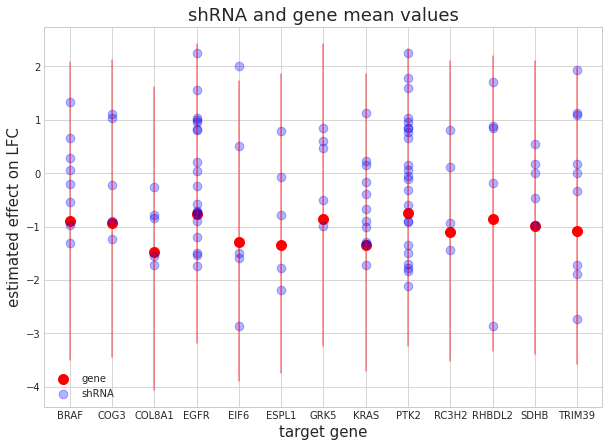

In [54]:
for i in range(fit3_gene_summary.shape[0]):
    plt.plot(np.repeat(fit3_gene_summary.loc[i, 'gene_symbol'], 2), 
             [fit3_gene_summary.loc[i, 'hpd_3%'], fit3_gene_summary.loc[i, 'hpd_97%']],
             color='red', alpha=0.5)


plt.scatter(fit3_gene_summary['gene_symbol'], 
            fit3_gene_summary['mean'],
            s=100, c='r', label='gene')
plt.scatter(fit3_alpha_summary['gene_symbol'], 
            fit3_alpha_summary['mean'], 
            alpha=0.3, s=75, c='b', label='shRNA')

plt.title('shRNA and gene mean values')
plt.xlabel('target gene')
plt.ylabel('estimated effect on LFC')
plt.legend()
plt.show()

## Model 4. Parameters for difference between average gene effect and cell line-specific effect

Note that the varying intercept for shRNA has been renamed from $\alpha$ to $c$.
$\bar g_{l}$ is the average effect of knocking-down gene $l$ while $g_{jl}$ is the cell line $j$-specific effect of knocking-down $l$.

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = c_{i|s} + \bar g_{i|l} + g_{i|jl} \\
c_s \sim N(0, \sigma_c) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_c \sim \text{HalfCauchy}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfCauchy}(0, 10) \\
\sigma_g \sim \text{HalfCauchy}(0, 5) \\
\sigma \sim \text{HalfCauchy}(0, 10)
$$

In [55]:
d2_m4_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    'J': np.max(modeling_data.cell_line_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    'cell_line': modeling_data.cell_line_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

**To-Do: issue with divergence.**

In [56]:
d2_m4_file = models_dir / 'd2_m4.cpp'
d2_m4 = StanModel_cache(file=d2_m4_file.as_posix())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0a855a3f523d114b7d0c0fc70dda7839 NOW.


No cached model - compiling '../models/d2_m4.cpp'.
0.73 minutes to compile model


In [57]:
d2_m4_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m4_fit = d2_m4.sampling(data=d2_m4_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m4_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [58]:
pystan.check_hmc_diagnostics(d2_m4_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': True,
 'energy': True}

In [59]:
az_d2_m4 = az.from_pystan(posterior=d2_m4_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m4)
az.summary(az_d2_m4).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_c,1.238,0.094,1.065,1.415,0.001,0.001,4762.0,4711.0,4835.0,5766.0,1.0
mu_gbar,-1.269,0.181,-1.618,-0.934,0.005,0.004,1280.0,1280.0,1270.0,2509.0,1.0
sigma_gbar,0.386,0.214,0.013,0.745,0.010,0.007,492.0,492.0,413.0,516.0,1.0
sigma_g,0.499,0.031,0.442,0.559,0.001,0.000,2089.0,2089.0,2091.0,4398.0,1.0
c[0],2.216,0.409,1.494,3.019,0.011,0.008,1318.0,1282.0,1353.0,2555.0,1.0


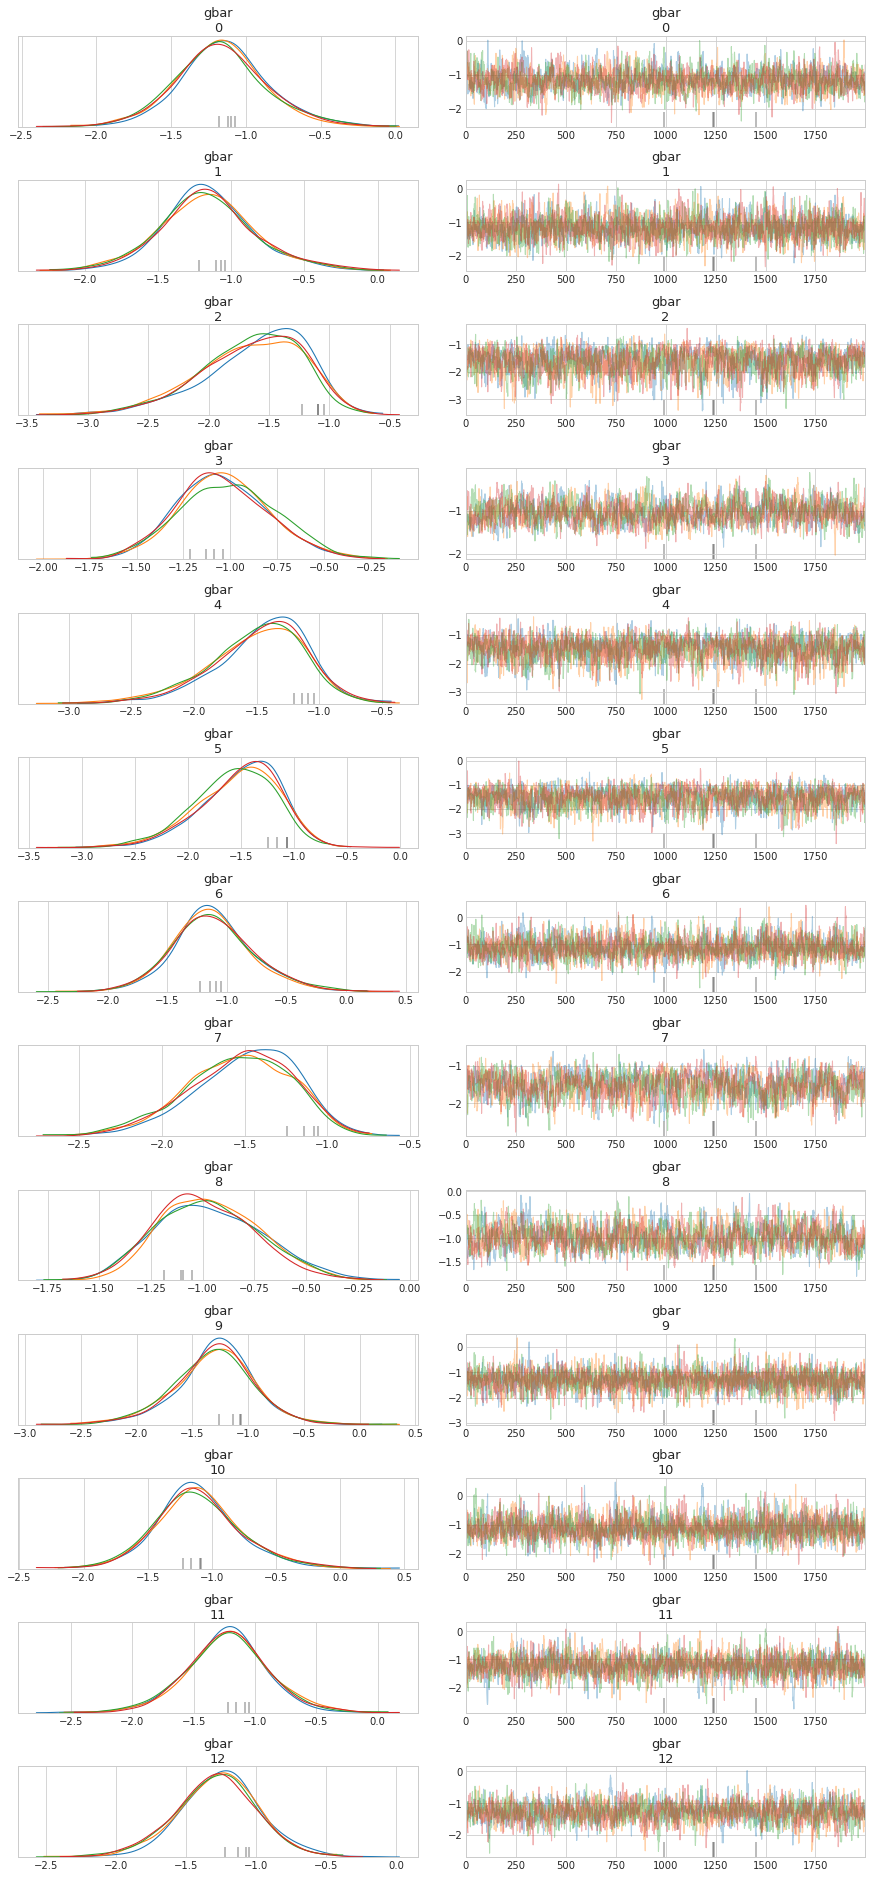

In [60]:
az.plot_trace(az_d2_m4, var_names=['gbar'])
plt.show()

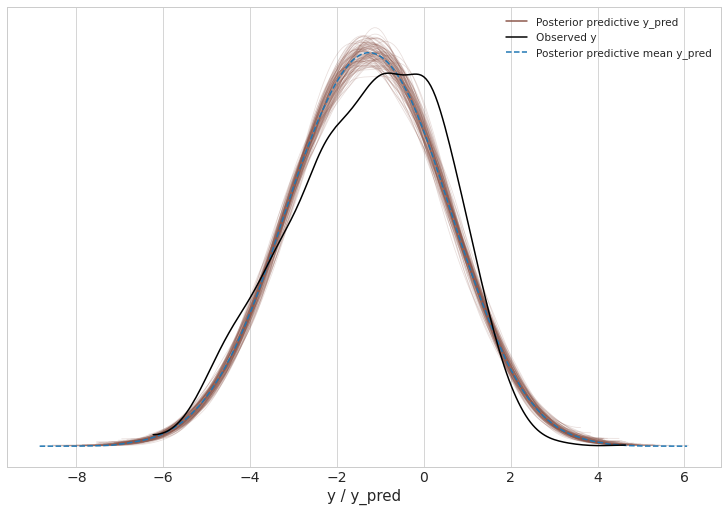

In [61]:
az.plot_ppc(az_d2_m4, data_pairs={'y':'y_pred'}, num_pp_samples=100)
plt.show()

**To-Do:** 

- show $g_{jl}$ for each gene
- show distribution of intercepts for shRNA $c_s$
- show distribution of values for cell lines